In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
import requests
import time

In [3]:
raw_data = pd.read_csv("game_data_public.STX.Sealed.csv")
raw_data.shape

(49381, 1388)

In [4]:
raw_data.head()

,user_win_rate_bucket,user_n_games_bucket,draft_id,build_index,draft_time,expansion,event_type,game_number,rank,opp_rank,...,sideboard_Waterfall Aerialist,sideboard_Weather the Storm,sideboard_Whirlwind Denial,sideboard_Witherbloom Apprentice,sideboard_Witherbloom Campus,sideboard_Witherbloom Command,sideboard_Witherbloom Pledgemage,sideboard_Wormhole Serpent,sideboard_Zephyr Boots,"sideboard_Zimone, Quandrix Prodigy"
0,0.00,1,19d851c33013406ab24112ced986b1b9,0,2021-04-20 06:33:09,STX,Sealed,1,NaN,NaN,...,0,0,0,0,3,0,1,0,0,0
1,0.00,1,19d851c33013406ab24112ced986b1b9,0,2021-04-20 06:33:09,STX,Sealed,1,NaN,NaN,...,0,0,0,0,3,0,1,0,0,0
2,0.62,5,17444d2b6e764adaa0786a9a1c792b7e,0,2021-04-15 15:47:47,STX,Sealed,1,NaN,NaN,...,0,0,0,0,0,0,1,1,0,1
3,0.62,5,17444d2b6e764adaa0786a9a1c792b7e,0,2021-04-15 15:47:47,STX,Sealed,1,NaN,NaN,...,0,0,0,0,0,0,1,1,0,1
4,0.62,5,17444d2b6e764adaa0786a9a1c792b7e,0,2021-04-15 15:47:47,STX,Sealed,1,NaN,NaN,...,0,0,0,0,0,0,1,1,0,1


In [5]:
raw_data.columns[:20]

Index(['user_win_rate_bucket', 'user_n_games_bucket', 'draft_id',
       'build_index', 'draft_time', 'expansion', 'event_type', 'game_number',
       'rank', 'opp_rank', 'on_play', 'num_mulligans', 'opp_num_mulligans',
       'opp_colors', 'num_turns', 'won', 'opening_hand_Abundant Harvest',
       'opening_hand_Academic Dispute', 'opening_hand_Academic Probation',
       'opening_hand_Access Tunnel'],
      dtype='object')

In [6]:
card_names = [col_name.replace('deck_', '') for col_name in raw_data.columns if col_name.startswith('deck_')]
card_names[-5:]

['Witherbloom Command',
 'Witherbloom Pledgemage',
 'Wormhole Serpent',
 'Zephyr Boots',
 'Zimone, Quandrix Prodigy']

In [7]:
len(card_names) # should be 343 = 275 (Strixhaven) + 63 (Mystical Archive) + 5 (Basic Land)

343

In [8]:
# Fetch card details from scryfall
try:
    card_details_df = pd.read_csv("card_details.csv")
except FileNotFoundError: 

    card_details_list = []

    for name in card_names:
        time.sleep(0.1)
        scryfall_result = requests.get(f"https://api.scryfall.com/cards/named?exact={name}").json()
        card_details = {}
        card_details['name'] = name
        card_details['rarity'] = scryfall_result['rarity']
        if 'oracle_text' in scryfall_result and 'learn' in scryfall_result['oracle_text'].lower():
            card_details['is_learn'] = True 
        else:
            card_details['is_learn'] = False
        if 'lesson' in scryfall_result['type_line'].lower():
            card_details['is_lesson'] = True 
        else:
            card_details['is_lesson'] = False
        card_details_list.append(card_details)

    card_details_df = pd.DataFrame.from_dict(card_details_list)
    card_details_df.to_csv("card_details.csv", index=False)

In [9]:
card_details_df.head(n=10)

,is_learn,is_lesson,name,rarity
0,False,False,Abundant Harvest,rare
1,True,False,Academic Dispute,uncommon
2,False,True,Academic Probation,rare
3,False,False,Access Tunnel,uncommon
4,False,False,Accomplished Alchemist,rare
5,False,False,Adventurous Impulse,common
6,False,False,Aether Helix,uncommon
7,False,False,Ageless Guardian,common
8,False,False,Agonizing Remorse,uncommon
9,False,False,Approach of the Second Sun,rare


In [10]:
card_details_df['is_lesson'].sum() # should be 20 lesson cards

20

In [11]:
lesson_names = list(card_details_df[card_details_df["is_lesson"]]["name"])

In [12]:
lesson_names

['Academic Probation',
 'Basic Conjuration',
 'Confront the Past',
 'Containment Breach',
 'Elemental Summoning',
 'Environmental Sciences',
 'Expanded Anatomy',
 'Fractal Summoning',
 'Illuminate History',
 'Inkling Summoning',
 'Introduction to Annihilation',
 'Introduction to Prophecy',
 'Mascot Exhibition',
 'Mercurial Transformation',
 'Necrotic Fumes',
 'Pest Summoning',
 'Reduce to Memory',
 'Spirit Summoning',
 'Start from Scratch',
 'Teachings of the Archaics']

In [13]:
# create a new df showing whether each lesson was available in the sideboard or not

new_columns = [raw_data["won"]]
for lesson_name in lesson_names:
    col = raw_data[f"sideboard_{lesson_name}"] > 0
    new_columns.append(col)
    
lesson_df = pd.concat(new_columns, axis=1)

In [14]:
lesson_df.head()

,won,sideboard_Academic Probation,sideboard_Basic Conjuration,sideboard_Confront the Past,sideboard_Containment Breach,sideboard_Elemental Summoning,sideboard_Environmental Sciences,sideboard_Expanded Anatomy,sideboard_Fractal Summoning,sideboard_Illuminate History,...,sideboard_Introduction to Annihilation,sideboard_Introduction to Prophecy,sideboard_Mascot Exhibition,sideboard_Mercurial Transformation,sideboard_Necrotic Fumes,sideboard_Pest Summoning,sideboard_Reduce to Memory,sideboard_Spirit Summoning,sideboard_Start from Scratch,sideboard_Teachings of the Archaics
0,False,False,False,False,False,False,False,True,False,False,...,True,True,False,False,False,True,False,False,True,False
1,False,False,False,False,False,False,False,True,False,False,...,True,True,False,False,False,True,False,False,True,False
2,True,False,False,False,False,True,True,True,False,False,...,True,True,False,False,False,False,False,False,False,False
3,True,False,False,False,False,True,True,True,False,False,...,True,True,False,False,False,False,False,False,False,False
4,False,False,False,False,False,True,True,True,False,False,...,True,True,False,False,False,False,False,False,False,False


In [25]:
diffs = {}
for lesson_name in lesson_names:
    diff = lesson_df[lesson_df[f"sideboard_{lesson_name}"] == True]["won"].mean() - \
           lesson_df[lesson_df[f"sideboard_{lesson_name}"] == False]["won"].mean()
    diffs[lesson_name] = diff

In [28]:
winrate_diffs = pd.Series(diffs).sort_values(ascending=False)

Text(0,0.5,'Winrate Delta')

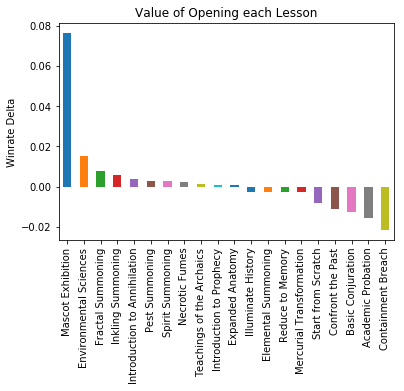

In [29]:
ax = winrate_diffs.plot.bar(title="Value of Opening each Lesson")
ax.set_ylabel("Winrate Delta")

In [34]:
lesson_df["sideboard_Containment Breach"].mean()

0.19928717522933923

In [44]:
diffs = {}
for i in range(100):
    random_sample = lesson_df.sample(frac=0.2)
    complement = lesson_df.drop(random_sample.index)
    diffs[i] = random_sample["won"].mean() - complement["won"].mean()
    
winrate_diffs = pd.Series(diffs).sort_values(ascending=False)

In [45]:
winrate_diffs[:5], winrate_diffs[-5:]

(23    0.014139
 34    0.012494
 13    0.012114
 87    0.011355
 19    0.011228
 dtype: float64, 75   -0.009403
 51   -0.010036
 94   -0.010162
 84   -0.013073
 1    -0.013453
 dtype: float64)